A bow shock has been detected near Cyg X-1 in two frequency bands using the MeerKAT. It appears that the jets from CygX-1 have plunged into the higher density ISM and created a bow shock, a semi-circular region seen on only one side of CygX-1. The jets from the black hole X-ray binary create a shock front, which creates an overpressured lobe. The continous pumping of gas into this lobe results in the sideways expansion of the lobe. In order to determine the energy transported to the ISM, the first step is to find out the density of the ISM near Cyg X-1. So the steps are as follows-
1) Find the electron density and temperature of the gas based on the comparison of radio vs Halpha surface brightness

    a) This would have been the most ideal case, but because the Halpha maps are contaminated heavily by the foreground stars, the Halpha flux and emitting area estimations are not solid.
    
    b) Instead, I will plot the curve of the relation between temperature and electron density, based off of the measured flux and volume of the bow shock from the MeerKAT image.

2) We will then use the temperature and electron density ranges to estimate the velocity of the bow shock. I will use the MC simulations here to ensure that the priors on the temperature and electron density are well accounted for in these estimations.

3) Using the velocity and the characteristic length of the jet, we can find the age of the jets.

4) The age will lead to the energy transport rate.

In [5]:
import astropy
from astropy import units as u
from astropy.units import cds
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.font_manager as font_manager
import matplotlib.gridspec as gridspec
from matplotlib import rc
from matplotlib import colors
import numpy as np
import numpy.ma as ma
import math
from scipy import interpolate
from scipy import optimize
from scipy.integrate import quad
from scipy.stats import rv_histogram

from scipy.stats import gaussian_kde,rv_continuous
from scipy.interpolate import interp1d

import scipy.special
import seaborn as sns
import pandas as pd

import joblib
from joblib import Parallel, delayed
import multiprocessing

import os


# Package versions:
print('Running on:')
print('Python version 3.6')
print(f'\tAstropy\t\t{astropy.__version__}')
print(f'\tMatplotlib\t{plt.matplotlib.__version__}')
print(f'\tNumpy\t\t{np.__version__}')
print(f'\tScipy\t\t{scipy.__version__}')
print(f'\tSeaborn\t\t{sns.__version__}')
print(f'\tPandas\t\t{pd.__version__}')
print(f'\tJoblib\t\t{joblib.__version__}')


Running on:
Python version 3.6
	Astropy		4.0.2
	Matplotlib	3.3.4
	Numpy		1.19.5
	Scipy		1.5.3
	Seaborn		0.11.2
	Pandas		1.1.5
	Joblib		0.13.2


In [2]:
# Set default figure size for all plots
plt.rcParams['figure.figsize'] = [12, 8]  # Width, Height in inches

#python3.6
rc('text', usetex=True)
font = {'family' : 'serif','size'   : 18}
rc('font', **font)

In [3]:
#New measured quantities in this work in L-band
F_total_L = 0.04693 #Integrated Bow shock flux in Jy
#F_total_L = 1.5e-4 #Integrated Bow shock flux in Jy if the bowshock was not deteted (sigma level)
F_L = 110e-6         #Mean Bow shock flux density in Jy/beam 
F_err_L = 1.5e-4 #rms from bowshock region
DRmin_L = 1.45           #Ring thickness, arcmin 
DRmin_err_L = 0.17
theam_L = 7.3      #Lobe diameter in arcmin (noted between the inner edges of the lobe)
disamin_L = 10.8 #angular seperation between Cyg X-1 and the leading edge of the bowshock in arcmin
disamin_err_L = 0.2 #(beam size is taken as the error)
proj_shock_L = 97771.6 #projected area of the bowshock in arcsec2 (used ds9 for this)
#New measured quantities in this work in S-band
F_total_S = 0.05927 #Integrated Bow shock flux in Jy
F_S = 38e-6         #Mean Bow shock flux density in Jy/beam 
F_err_S = 4.8e-5 #rms from bowshock region
DRmin_S = 1.39           #Ring thickness, arcmin 
DRmin_err_S = 0.18
theam_S = 7      #Lobe diameter in arcmin (noted between the inner edges of the lobe)
disamin_S = 10.5 #angular seperation between Cyg X-1 and the leading edge of the bowshock in arcmin
disamin_err_S = 0.12 #(beam size is taken as the error)
proj_shock_S = 95688.6 #projected area of the bowshock in arcsec2 (used ds9 for this)
#Literature Source specific quantities 
d = 2.2            #distance to Cyg X-1 in kpc, Miller-Jones et al. 2021
d_err = 0.18        #error in distance measured 
incl = 27.51        #inclination angle, Miller-Jones et al. 2021
incl_err = 0.18     #error inclination angle, Miller-Jones et al. 2021
o_a = 30             #opening angle
o_a_err = 0         #opening angle error

In [4]:
#Constants

pc = 3.086E+18       # 1 pc, cm 
mh = 1.6735575E-24   # Hydrogen mass, g 
me = 9.1093837E-28   # Electron mass, g 
eV = 1.602176634E-12 # ElectronVolt, erg
Jy = 1.0E-23         # 1 Jansky (erg/s/cm2/Hz), cgs
kb = 1.380649E-16;   # K boltzman, cgs
h =  6.6261E-27;     # Plank constant, cgs 
c = 3.0e10           # Speed of light, cgs 
Na = 6.022E+23       # Avogadro's number
Z=1                  # Hydrogen atomic number
e = 4.8e-10          #electric charge cm3/2 g1/2 s-1
x=1                  #ionisation fraction
C_radio = 6.8*1e-38
Gammac = 5/3                            # Adiabatic index of the material in the cavity, -- ASSUMED 
Gammax = 5/3                            # Adiabatic index of the material in the external medium, -- ASSUMED 
Gammaj = 5/3                            # Adiabatic index of the material in the jet, -- ASSUMED 
beta = 0                                # density profile index (beta = 0 for a uniform density medium), -- ASSUMED 

# Observation-specific quantities L-band
nu_L = 1.2839E+9;         # Observing frequency (L-band, MeerKAT, slightly lower than for Cyg X-1, Westerbork)
bmaj_L = 14.26            # Beam major axis, arcsec
bmin_L = 14.26            # Beam minor axis, arcsec

# Observation-specific quantities S-band
nu_S = 2.624E+9;         # Observing frequency (L-band, MeerKAT, slightly lower than for Cyg X-1, Westerbork)
bmaj_S = 7.009            # Beam major axis, arcsec
bmin_S = 7.009            # Beam minor axis, arcsec

## Conversion of the newly measured source specific quantities L-band

In [5]:
#various aspects of the ring thickness
DR_L = DRmin_L*60      #Ring thickness, arcsec
DRpc_L = d*1e3*4.8*1e-6*DR_L #Ring thickness in pc (have to convert d to pc from kpc too)
DRcm_L = DRpc_L*pc    #Ring thickness in cm 

DR_err_L = DRmin_err_L*60
DRpc_err_L = d*1e3*4.8*1e-6*DR_err_L #Ring thickness in pc (have to convert d to pc from kpc too)
DRcm_err_L = DRpc_err_L*pc    #Ring thickness in cm 

#various aspects of the area of of the bowshock
proj_shock_pc_L = proj_shock_L*(d*1e3*4.8*1e-6)**2 #convert area from arcsec to pc
proj_volume_pc_L = DRpc_L*proj_shock_pc_L #convert the pc area to pc volume
proj_vol_cm_L = proj_volume_pc_L*((pc)**3) #convert the pc volume to cm3 volume

#Various aspects of the lobe diameter
lobesize_as_L = theam_L*60 #lobe diameter in arcseconds
lobesizepc_L = lobesize_as_L*d*1e3*4.8*1e-6    #lobe diameter in pc
lobesizecm_L = lobesizepc_L*pc      #lobe diameter in cm

#Various aspects of the angular seperation between the target and the leading edge of the bowshock
disasec_L = disamin_L*60 #lobe target seperation in arcsec (projected)
dispc_L = disasec_L*d*1e3*4.8*1e-6  #lobe target separation in pc (projected)
discmP_L = dispc_L*pc #lobe target sepeartion in cm (projected)
discm_deP_L = discmP_L/math.sin(incl*math.pi/180) #lobe target de-projected seperation to account for the inclination angle

#Printing the estimated values
print('Bow shock thickness in cm -','%.3e'%DRcm_L)
print('Diameter of the bowshock in cm -', '%.3e'%lobesizecm_L)
print('Seperation between Cyg X-1 and the bowshock in cm (de-projected) -', '%.3e'%discm_deP_L) #Lj
print('Bow shock thickness in pc -','%.3f'%DRpc_L)
print('Diameter of the bowshock in pc -', '%.3f'%lobesizepc_L)
print('Seperation between Cyg X-1 and the bowshock in pc (projected) -', '%.3f'%dispc_L) #Lj
print('Bow shock Volume in pc3 -','%.3e'%proj_volume_pc_L)
print('Bow shock Area in pc2 -','%.3e'%proj_shock_pc_L)

Bow shock thickness in cm - 2.835e+18
Diameter of the bowshock in cm - 1.427e+19
Seperation between Cyg X-1 and the bowshock in cm (de-projected) - 4.572e+19
Bow shock thickness in pc - 0.919
Diameter of the bowshock in pc - 4.625
Seperation between Cyg X-1 and the bowshock in pc (projected) - 6.843
Bow shock Volume in pc3 - 1.002e+01
Bow shock Area in pc2 - 1.090e+01


## Conversion of the newly measured source specific quantities S-band

In [6]:
DR_S = DRmin_S*60      #Ring thickness, arcsec
DRpc_S = d*1e3*4.8*1e-6*DR_S #Ring thickness in pc (have to convert d to pc from kpc too)
DRcm_S = DRpc_S*pc    #Ring thickness in cm 

DR_err_S = DRmin_err_S*60
DRpc_err_S = d*1e3*4.8*1e-6*DR_err_S #Ring thickness in pc (have to convert d to pc from kpc too)
DRcm_err_S = DRpc_err_S*pc    #Ring thickness in cm 

#various aspects of the area of of the bowshock
proj_shock_pc_S = proj_shock_S*(d*1e3*4.8*1e-6)**2 #convert area from arcsec to pc
proj_volume_pc_S = DRpc_S*proj_shock_pc_S #convert the pc area to pc volume
proj_vol_cm_S = proj_volume_pc_S*((pc)**3) #convert the pc volume to cm3 volume

#Various aspects of the lobe diameter
lobesize_as_S = theam_S*60 #lobe diameter in arcseconds
lobesizepc_S = lobesize_as_S*d*1e3*4.8*1e-6    #lobe diameter in pc
lobesizecm_S = lobesizepc_S*pc      #lobe diameter in cm

#Various aspects of the angular seperation between the target and the leading edge of the bowshock
disasec_S = disamin_S*60 #lobe target seperation in arcsec (projected)
dispc_S = disasec_S*d*1e3*4.8*1e-6  #lobe target separation in pc (projected)
discmP_S = dispc_S*pc #lobe target sepeartion in cm (projected)
discm_deP_S = discmP_S/math.sin(incl*math.pi/180) #lobe target de-projected seperation to account for the inclination angle

#Printing the estimated values
print('Bow shock thickness in cm -','%.3e'%DRcm_S)
print('Diameter of the bowshock in cm -', '%.3e'%lobesizecm_S)
print('Seperation between Cyg X-1 and the bowshock in cm (de-projected) -', '%.3e'%discm_deP_S) #Lj
print('Bow shock thickness in pc -','%.3f'%DRpc_S)
print('Diameter of the bowshock in pc -', '%.3f'%lobesizepc_S)
print('Seperation between Cyg X-1 and the bowshock in pc (projected) -', '%.3f'%dispc_S) #Lj
print('Bow shock Volume in pc3 -','%.3e'%proj_volume_pc_S)
print('Bow shock Area in pc2 -','%.3e'%proj_shock_pc_S)

Bow shock thickness in cm - 2.718e+18
Diameter of the bowshock in cm - 1.369e+19
Seperation between Cyg X-1 and the bowshock in cm (de-projected) - 4.445e+19
Bow shock thickness in pc - 0.881
Diameter of the bowshock in pc - 4.435
Seperation between Cyg X-1 and the bowshock in pc (projected) - 6.653
Bow shock Volume in pc3 - 9.398e+00
Bow shock Area in pc2 - 1.067e+01


### Finding the electron density and temperature

The radio emissivity as given by (Longair 2011): The monochromatic emissivity $\epsilon_\nu$ of ionised hydrogen due to thermal bremsstrahlung is given by (Longair 1994). 

 $$\epsilon_\nu = \frac{L_\nu}{V} = 6.8\times 10^{-38} g(\nu, T) \frac{n_e^2}{\sqrt{T}} \exp{(\frac{h\nu}{k_b T})} ~~ erg~s^{-1}~cm^{-3}~Hz^{-1}$$

where $V$ is the volume of the emitting region. The way we estimate this is to find the area of the selected region in arcsec2 and multiply it by the thickness of the ring, assuming it to be as deep as it is wide. 

$$
L_\nu = F_\nu \times 4\pi \times d^2
$$
, which is the monochromatic luminosity. In the case of MeerKAT, we use monochromatic flux density ($F_\nu$) to present the flux density of a flat spectrum source at the central frequency of the observing band, and under the solid assumption that the flux does not change within the MeerKAT bandwidth. Another thing to note is that this is the integrate flux of the bowshock, as we are using the total volume of the emitting region to find the emissivity.

From the Bremsstrahlung emissivity we can derive the electron density, and from there the total number of particles based on the expected ionisation fraction $x \sim 1$ of a hydrogen gas emitting at a minimum temperature of T $\sim 10{^4}$ K. At these temperatures almost all hydrogen will be ionised, so the ionisation fraction is 1.

$$n_e = \sqrt\frac{\epsilon_\nu}{g(\nu, T) \sqrt{T} C_{radio}}$$

where,

$$ 
C_{radio} = 6.8\times 10^{-38} erg~s^{-1}~cm^{-3}~Hz^{-1} 
$$,

$$
g(\nu, T) \approx \frac{\sqrt{3}}{2 \pi}\left[\ln \left(\frac{128 \epsilon_0^2 k^3 T^3}{m_e e^4 \nu^2 Z^2}\right)-\gamma^2\right]
$$

### To calculate the electron density using MC

In [7]:
def gaunt(nu, T, z):
    # The Gaunt factor  
    F1 = 128.*(1**2)*(kb**3)*(T**3)
    F2 = me * (e**4)*(nu**2)*(z**2)
    G = (3**0.5 / (2.*np.pi)) * (np.log(F1/F2) - 0.5772156649**2)
    return G

In [8]:
%matplotlib notebook
n_iter = 10000
n_cores = 16         # Number of parallel threads

In [9]:
class custom_dist_analytical(rv_continuous):
    def _pdf(self, xx):
        return testf(xx)

np.random.seed(124)

In [10]:
def ne(d,F,DR,T_axis,nu,Z,proj_shock):
    L14 = F*Jy*4*math.pi*(d*1e3*pc)**2 # Monochormatic ring luminosity in erg/sec/Hz
    Vol = (DR*proj_shock*(d*1e3*4.8*1e-6*pc)**3)
    kappa_nu = L14 / Vol
    ne_squared = kappa_nu/(C_radio*(T_axis**-0.5) * gaunt(nu, T_axis, Z))
    n_e = (ne_squared**0.5) # units: cm^-3
    return n_e


In [11]:
# Creating distributions for source parameters that remain unchanged for both frequencies parameters:
dist = np.random.normal(d,d_err, n_iter)
T_axis = np.linspace(10**4,3*(10**6), n_iter, endpoint=True)
T_axis_log = np.logspace(4,8,num=n_iter,base=10,endpoint=True)

In [12]:
#Creating distributions for source parameters that change for each frequency
Flux_L = np.random.normal(F_total_L,F_err_L,n_iter)
Ring_thic_L = np.random.normal(DR_L,DR_err_L,n_iter) #ring thickness in arcsec
Flux_S = np.random.normal(F_total_S,F_err_S,n_iter)
Ring_thic_S = np.random.normal(DR_S,DR_err_S,n_iter) #ring thickness in arcsec

In [13]:
elec_density_L = Parallel(n_jobs=n_cores,verbose=5)(delayed(ne)(dist[i],Flux_L[i],Ring_thic_L[i],T_axis_log[i],nu_L,Z,proj_shock_L) for i in range(n_iter))
elec_density_S = Parallel(n_jobs=n_cores,verbose=5)(delayed(ne)(dist[i],Flux_S[i],Ring_thic_S[i],T_axis_log[i],nu_S,Z,proj_shock_S) for i in range(n_iter))

[Parallel(n_jobs=16)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  40 tasks      | elapsed:    6.4s
[Parallel(n_jobs=16)]: Done 247 tasks      | elapsed:    6.9s
[Parallel(n_jobs=16)]: Done 10000 out of 10000 | elapsed:    7.8s finished
[Parallel(n_jobs=16)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done 208 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 10000 out of 10000 | elapsed:    0.8s finished


In [14]:
ner_L_T = ne(d,F_total_L,DR_L,T_axis_log,nu_L,Z,proj_shock_L) #only with temperature variation
ner_S_T = ne(d,F_total_S,DR_S,T_axis_log,nu_S,Z,proj_shock_S) #only with temperature variation

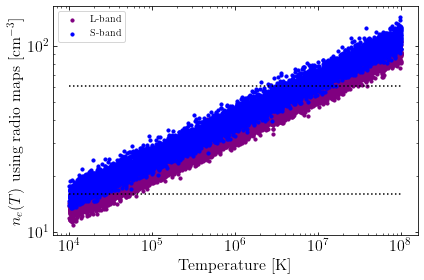

In [15]:
%matplotlib inline
#To plot the variation of ne with T_axis
fig = plt.figure()
ax = fig.add_subplot(111)
ax.tick_params(axis='both', which='both', labelsize=16)
ax.yaxis.set_ticks_position('both')
ax.xaxis.set_ticks_position('both')
ax.get_yaxis().set_tick_params(direction='in', which='both')
ax.get_xaxis().set_tick_params(direction='in', which='both')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel(r'Temperature [K]',fontsize=16)
ax.set_ylabel(r'$n_e(T)$ using radio maps [cm$^{-3}$]',fontsize=16)
plt.tight_layout()
plt.hlines([16,61],1e4,1e8,linestyles=':',colors='black')
plt.scatter(T_axis_log,elec_density_L,s=10,color='purple',label='L-band')
plt.scatter(T_axis_log,ner_L_T,s=1,color='purple')
plt.scatter(T_axis_log,elec_density_S,s=10,color='blue',label='S-band')
plt.scatter(T_axis_log,ner_S_T,s=1,color='blue')
plt.legend()
plt.show()
# plt.savefig('./ihavetocheckthis.pdf')

34.23901205823127 21.06840927622778 56.109299517292534


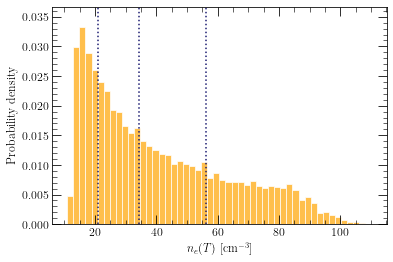

In [16]:
#Plotting histogram of electron density using L-band observations
median_L = np.nanpercentile(elec_density_L,50)
low_lim_L = np.nanpercentile(elec_density_L,25)
high_lim_L = np.nanpercentile(elec_density_L,75)
print(median_L,low_lim_L,high_lim_L)
histplot = plt.hist(elec_density_L,bins=50,color='orange',edgecolor='w',density=True,alpha=0.7)
plt.vlines([low_lim_L,high_lim_L],0,max(histplot[0])*1.1,linestyles=':',colors='midnightblue')
plt.vlines(median_L,0,max(histplot[0])*1.1,linestyles=':',colors='midnightblue')
plt.ylim(0,max(histplot[0])*1.1)
plt.ylabel('Probability density', fontsize=12)
plt.xlabel(r'$n_e(T)$ [cm$^{-3}$]', fontsize=12)
#plt.xlim(0,400)
#plt.title(str(name))
plt.minorticks_on()
plt.tick_params(axis='both', which='major', labelsize=12)
plt.tick_params(axis='both', which='major', length=9)
plt.tick_params(axis='both', which='minor', length=4.5)
plt.tick_params(axis='both', which='both',direction='in',right=True,top=True)
plt.show()

40.436810272490334 24.772696819160018 66.7154615116302


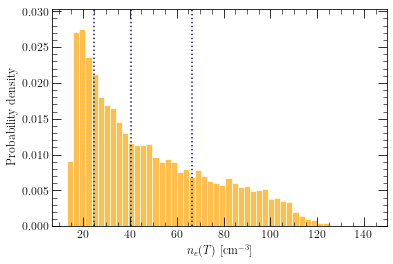

In [17]:
#Plotting histogram of electron density using S-band observations

median_S = np.nanpercentile(elec_density_S,50)
low_lim_S = np.nanpercentile(elec_density_S,25)
high_lim_S = np.nanpercentile(elec_density_S,75)
print(median_S,low_lim_S,high_lim_S)
histplot = plt.hist(elec_density_S,bins=50,color='orange',edgecolor='w',density=True,alpha=0.7)
plt.vlines([low_lim_S,high_lim_S],0,max(histplot[0])*1.1,linestyles=':',colors='midnightblue')
plt.vlines(median_S,0,max(histplot[0])*1.1,linestyles=':',colors='midnightblue')
plt.ylim(0,max(histplot[0])*1.1)
plt.ylabel('Probability density', fontsize=12)
plt.xlabel(r'$n_e(T)$ [cm$^{-3}$]', fontsize=12)
plt.minorticks_on()
plt.tick_params(axis='both', which='major', labelsize=12)
plt.tick_params(axis='both', which='major', length=9)
plt.tick_params(axis='both', which='minor', length=4.5)
plt.tick_params(axis='both', which='both',direction='in',right=True,top=True)
plt.show()

## Calculating electron density with H alpha observations

We can find a similar relation by considering the H $\alpha$ surface brightness. For this, we can use the equation in Gvaramadze et al. (2018):

$$j_{\rm H\alpha} = 2.85\times10^{-33}\text{erg s}^{-1}\text{ cm}^{-3}\text{ arcsec}^{-2} \left( \frac{T}{\text{K}} \right)^{-0.9}\left(\frac{n_e}{\text{cm}^{-3}}\right)^2$$

The temperature and $n_e$ depend on position, but in our analysis, we have assumed they are uniform with depth. So then, we find that the surface brightness is given by:

$$S_{\rm H\alpha} = \int j_{\rm H\alpha}(x) dx = j_{\rm H\alpha} \Delta$$

Thus:

$$n_e(T) = \sqrt{S_{\rm H\alpha}\frac{(T/\text{K})^{0.9}}{C_{\rm H\alpha}\Delta}} \text{ cm}^{-3}$$ 

where $C_{\rm H\alpha} = 2.85\times10^{-33}\text{erg s}^{-1}\text{ cm}^{-3}\text{ arcsec}^{-2}$ and $\Delta$ is the width of the bowshock in cm.



In [18]:
Sh = 1.4e-17 * u.erg * ((u.second)**-1)*((u.cm)**-2)*((u.arcsecond)**-2) #obtained from Russell et al 2007 Table 2 and has the units ergs s-1 cm-2 arcsec-2
Sh_err = 1.4e-18 #assuming a 10% error margin on Sh
Ch = 2.85e-33* u.erg * ((u.second)**-1)*((u.cm)**-3)*((u.arcsecond)**-2) #Units of erg s-1 cm-3 arcsec-2
Halpha_thic_min = 6*u.arcsecond #min thickness from Russell 2007
Halpha_thic_max = 40*u.arcsecond #max thickness from Russell 2007

D = 2.2e3 *u.parsec
Halpha_thic_min_arcsec = Halpha_thic_min.to(u.arcsec)
arcsec_to_size = (1 * u.arcsec).to(u.radian).value * D # the conversion between arcsecond to size at the distance of Cyg X-1
Halpha_thic_min_parsec = (Halpha_thic_min.value*arcsec_to_size)
Halpha_thic_min_cm = Halpha_thic_min_parsec.to(u.cm)

Halpha_thic_max_arcsec = Halpha_thic_max.to(u.arcsec)
Halpha_thic_max_parsec = (Halpha_thic_max.value*arcsec_to_size)
Halpha_thic_max_cm = Halpha_thic_max_parsec.to(u.cm)

Ring_thic_tab2 = 1.6e18*u.cm #russell 2007 average thickness in Table 2 to be used for calculations here
Ring_thic_tab2_err = 1.6e17*u.cm #assuming 10% error bar
# Source parameters, :
Halpha_Flux = np.random.normal(Sh.value,Sh_err,n_iter)
#Ring_thic_cm = np.random.uniform(Halpha_thic_min_cm.value,Halpha_thic_max_cm.value,n_iter)
Ring_thic_cm = np.random.normal(Ring_thic_tab2.value,Ring_thic_tab2_err.value,n_iter)
def ha_ne(S,T,Ring):
    Ha_ne = ((S*(T**0.9))/(Ch.value*Ring))**0.5
    return(Ha_ne)

In [19]:
elec_density_Ha = Parallel(n_jobs=n_cores,verbose=5)(delayed(ha_ne)(Halpha_Flux[i],T_axis_log[i],Ring_thic_cm[i]) for i in range(n_iter))

[Parallel(n_jobs=16)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  41 tasks      | elapsed:    0.4s
[Parallel(n_jobs=16)]: Done 2660 tasks      | elapsed:    1.0s
[Parallel(n_jobs=16)]: Done 10000 out of 10000 | elapsed:    1.0s finished


In [20]:
neh_T = ha_ne(Sh.value,T_axis_log,Ring_thic_tab2.value) #only with temperature variation

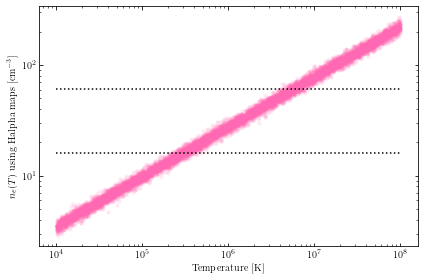

In [21]:
#To plot the variation of Halpha_ne with T_axis
fig = plt.figure()
ax = fig.add_subplot(111)
ax.yaxis.set_ticks_position('both')
ax.xaxis.set_ticks_position('both')
ax.get_yaxis().set_tick_params(direction='in', which='both')
ax.get_xaxis().set_tick_params(direction='in', which='both')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel(r'Temperature [K]', fontsize=10)
ax.set_ylabel(r'$n_e(T)$ using Halpha maps [cm$^{-3}$]', fontsize=10)
plt.tight_layout()
plt.hlines([16,61],1e4,1e8,linestyles=':',colors='black')
plt.scatter(T_axis_log,elec_density_Ha,s=10,color='hotpink',alpha=0.1)
plt.scatter(T_axis_log,neh_T,s=1,color='hotpink')
plt.show()

27.93290578944705 9.863673878587662 78.03080137305608


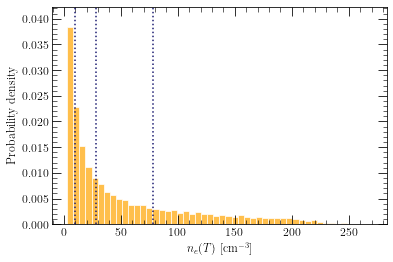

In [22]:
#Plotting histogram of electron density using Halpha observations
median = np.nanpercentile(elec_density_Ha,50)
low_lim = np.nanpercentile(elec_density_Ha,25)
high_lim = np.nanpercentile(elec_density_Ha,75)
print(median,low_lim,high_lim)
histplot = plt.hist(elec_density_Ha,bins=50,color='orange',edgecolor='w',density=True,alpha=0.7)
plt.vlines([low_lim,high_lim],0,max(histplot[0])*1.1,linestyles=':',colors='midnightblue')
plt.vlines(median,0,max(histplot[0])*1.1,linestyles=':',colors='midnightblue')
plt.ylim(0,max(histplot[0])*1.1)
plt.ylabel('Probability density', fontsize=12)
plt.xlabel(r'$n_e(T)$ [cm$^{-3}$]', fontsize=12)
#plt.xlim(0,400)
#plt.title(str(name))
plt.minorticks_on()
plt.tick_params(axis='both', which='major', labelsize=12)
plt.tick_params(axis='both', which='major', length=9)
plt.tick_params(axis='both', which='minor', length=4.5)
plt.tick_params(axis='both', which='both',direction='in',right=True,top=True)
plt.show()

## Making combined histograms for comparision

34.23901205823127 14.347392483624013 84.74283341139373
27.93290578944705 4.291331499850193 179.77080715887087


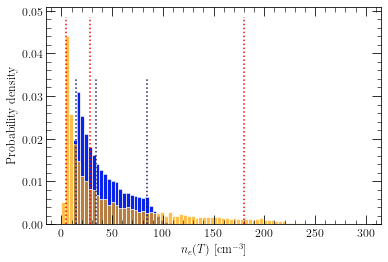

In [23]:
_, bins, _ = plt.hist(elec_density_L, bins=80, range=[0, 300], density=True)

median_1 = np.nanpercentile(elec_density_L,50)
low_lim_1 = np.nanpercentile(elec_density_L,5)
high_lim_1 = np.nanpercentile(elec_density_L,95)
print(median_1,low_lim_1,high_lim_1)
histplot_1 = plt.hist(elec_density_L,bins=bins,color='blue',edgecolor='w',density=True,alpha=0.7)
plt.vlines([low_lim_1,high_lim_1],0,max(histplot_1[0])*1.1,linestyles=':',colors='midnightblue')
plt.vlines(median_1,0,max(histplot_1[0])*1.1,linestyles=':',colors='midnightblue')

median_2 = np.nanpercentile(elec_density_Ha,50)
low_lim_2 = np.nanpercentile(elec_density_Ha,5)
high_lim_2 = np.nanpercentile(elec_density_Ha,95)
print(median_2,low_lim_2,high_lim_2)
histplot_2 = plt.hist(elec_density_Ha,bins=bins,color='orange',edgecolor='w',density=True,alpha=0.7)
plt.vlines([low_lim_2,high_lim_2],0,max(histplot_2[0])*1.1,linestyles=':',colors='red')
plt.vlines(median,0,max(histplot_2[0])*1.1,linestyles=':',colors='red')
#plt.ylim(0,max(histplot_2[0])*1.1)
plt.ylabel('Probability density', fontsize=12)
plt.xlabel(r'$n_e(T)$ [cm$^{-3}$]', fontsize=12)
#plt.xlim(0,250)
#plt.title('Distribution of electron number density using H alpha maps')
plt.minorticks_on()
plt.tick_params(axis='both', which='major', labelsize=12)
plt.tick_params(axis='both', which='major', length=9)
plt.tick_params(axis='both', which='minor', length=4.5)
plt.tick_params(axis='both', which='both',direction='in',right=True,top=True)
plt.show()

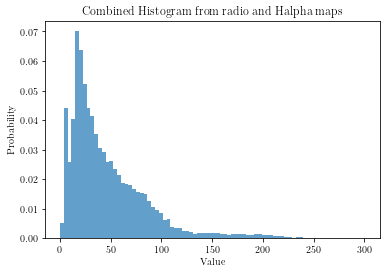

In [24]:
# Create histograms for both samples
hist1, bins1 = np.histogram(elec_density_L, bins=bins, density=True)
hist2, bins2 = np.histogram(elec_density_S, bins=bins, density=True)
hist3, bins3 = np.histogram(elec_density_Ha, bins=bins, density=True)


# Combine histograms
combined_hist = hist1 + hist2 +hist3
bin_centers = (bins1[:-1] + bins1[1:]) / 2

# Plot the combined histogram
plt.bar(bin_centers, combined_hist, width=bins1[1] - bins1[0], alpha=0.7)
plt.xlabel("Value")
plt.ylabel("Probability")
plt.title("Combined Histogram from radio and Halpha maps")
plt.show()

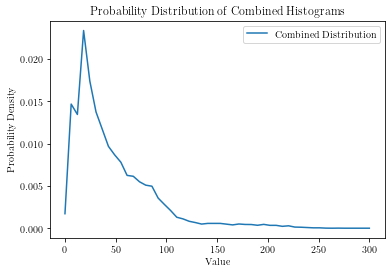

In [25]:
# Create a scipy.stats distribution from the combined histogram
hist_dist = rv_histogram((combined_hist, bins1))

# Plot the probability distribution
x = np.linspace(min(bins1), max(bins1), 50)
plt.plot(x, hist_dist.pdf(x), label="Combined Distribution")
plt.xlabel("Value")
plt.ylabel("Probability Density")
plt.title("Probability Distribution of Combined Histograms")
plt.legend()
plt.show()

In [26]:
#median = hist_dist.median()
# Calculate the 25th percentile
percentile_25 = hist_dist.ppf(0.25)
percentile_50 = hist_dist.ppf(0.50)
# Calculate the 75th percentile
percentile_75 = hist_dist.ppf(0.75)
print(percentile_25,percentile_50,percentile_75)

19.599707357859533 35.155538694992416 64.36324167872651


## Finding overlap region between Halpha and radio ISM density

Temperature range that satisfies all three distributions: 853086.5588540772 K to 14856523.41322157 K
Electron density range that satisfies all three distributions: 28.876024406390382 cm^-3 to 78.93605400301996 cm^-3


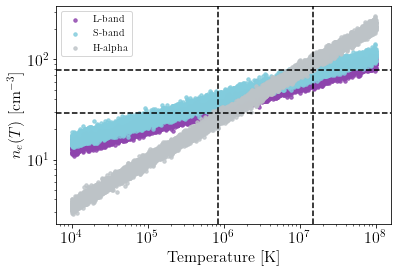

In [36]:
# Find overlapping electron densities

ne_min = np.maximum(np.minimum(elec_density_L, elec_density_S), elec_density_Ha)
ne_max = np.minimum(np.maximum(elec_density_L, elec_density_S), elec_density_Ha)

# Identify temperature range that satisfies all three distributions
overlap_indices = np.where(ne_min <= ne_max)
T_overlap = T_axis_log[overlap_indices]
ne_overlap_min = ne_min[overlap_indices]
ne_overlap_max = ne_max[overlap_indices]

# Plot the results
#plt.figure(figsize=(12, 8))
plt.scatter(T_axis_log, elec_density_L, label='L-band', color='#8e44ad', alpha=0.8,s=12) 
plt.scatter(T_axis_log, elec_density_S, label='S-band', color='#82ccdd', alpha=0.8,s=12)  
plt.scatter(T_axis_log, elec_density_Ha, label='H-alpha', color='#bdc3c7', alpha=0.8,s=12) 

# Add vertical lines for the temperature range
plt.axvline(x=T_overlap[0], color='black', linestyle='--')
plt.axvline(x=T_overlap[-1], color='black', linestyle='--')

# Add horizontal lines for the electron density range
plt.axhline(y=ne_overlap_min.min(), color='black', linestyle='--')
plt.axhline(y=ne_overlap_max.max(), color='black', linestyle='--')
plt.xscale('log')
plt.yscale('log')
plt.legend(fontsize=10)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.xlabel('Temperature [K]', fontsize=16)
plt.ylabel(r'$n_e(T)$ [cm$^{-3}$]', fontsize=16)
plt.show()

# Print the temperature range that satisfies all three distributions
print(f"Temperature range that satisfies all three distributions: {T_overlap[0]} K to {T_overlap[-1]} K")
print(f"Electron density range that satisfies all three distributions: {ne_overlap_min.min()} cm^-3 to {ne_overlap_max.max()} cm^-3")

#plt.savefig('./ne_neh.pdf',bbox_inches='tight')

## Shock velocity measurement:

Velocity of the bow shock can be estimated by the velocity of the leading end of the shock, which is dictated by the velocity of the end of the shocking jet.

$$ \dot{L} = \sqrt{\frac{16 k_b}{3 m_p}T}$$

where $m_p$ is the mass of the proton. 
For a strong shock in a mono-atomic gas, the expansion velocity is set by the temperature of the shocked gas. If the shock is radiative the initial post-shock temperature can be higher than that of the thermalized, bremsstrahlung-emitting gas. A stringent constraint comes from X-ray observations and the upper limit to the gas temperature was set at T ~ 10 $^6$ K in G05. During estimation of the ISM density, we considered temperatures all the way up to T ~ 10 $^8$ K because of the fact that the emission is assumed to be bremsstrahlung. 

In [42]:
T_axis = np.linspace(T_overlap[0],T_overlap[-1], n_iter, endpoint=True)
#T_axis_log = np.logspace(4,8,num=n_iter,base=10,endpoint=True)
#T_axis_new_log = np.logspace(5,7,num=n_iter,base=10,endpoint=True)
v_range = ( (16*T_axis*kb)/(3*mh) )**(1/2)/1e5
v_range_cm = ( (16*T_axis*kb)/(3*mh) )**(1/2)

Velocity range 193.73908118777933 808.4986181354388


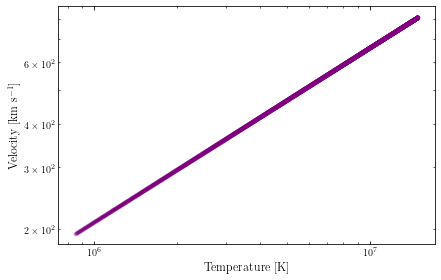

In [43]:
#To plot the variation of ne with T_axis and adding the 25th and 95th percentiles as ne ranges
fig = plt.figure()
ax = fig.add_subplot(111)
ax.yaxis.set_ticks_position('both')
ax.xaxis.set_ticks_position('both')
ax.get_yaxis().set_tick_params(direction='in', which='both')
ax.get_xaxis().set_tick_params(direction='in', which='both')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel(r'Temperature [K]', fontsize=12)
ax.set_ylabel(r'Velocity [km s$^{-1}$]', fontsize=12)
plt.tight_layout()
plt.scatter(T_axis,v_range,s=10,color='purple',alpha=0.1)
print('Velocity range',v_range[0],v_range[n_iter-1])

## Jet age measurement:

$$ t = \frac{3 L_j}{5 \dot{L_j}} $$

where $L_j$ is the seperation between the leading edge of the bowshock and the target and $\dot{L_j}$ is the velocity of the bow shock estimated from the temperature of the ISM. Since the angular seperation between the leading edge of the bow shock and Cyg X-1 is the same in both the L and S-band, we use only one estimate to derive the jet age, and more appropriately S-band due to the higher resolution measurement. 

In [44]:
def age(disamin,d,incl,v):
    disasec = disamin*60 #lobe target seperation in arcsec (projected)
    dispc = disasec*d*1e3*4.8*1e-6  #lobe target separation in pc (projected)
    discmP = dispc*pc #lobe target sepeartion in cm (projected)
    discm = discmP/math.sin(incl*math.pi/180) #lobe target de-projected seperation to account for the inclination angle
    t = 3/5*(discm/v) #time in seconds
    t_age_Myr = t/(365.*24.*60*60)/1.0E+6 #age of shock in Myr
    return t_age_Myr
    

In [45]:
# Generating distribution arrays for measurements
len_min = np.random.normal(disamin_S,disamin_err_S, n_iter) #distance between bowshock and target in arcmin
i_angle = np.random.normal(incl,incl_err,n_iter)  #inclination angle
#Obtaining distribution of age for different input parameters
t_age = Parallel(n_jobs=n_cores,verbose=5)(delayed(age)(len_min[i],dist[i],i_angle[i],v_range_cm[i]) for i in range(n_iter))

[Parallel(n_jobs=16)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  40 tasks      | elapsed:    6.0s
[Parallel(n_jobs=16)]: Done 409 tasks      | elapsed:    6.2s
[Parallel(n_jobs=16)]: Done 10000 out of 10000 | elapsed:    7.3s finished


0.014390902497025189 0.011961009772505863 0.019417152300375627


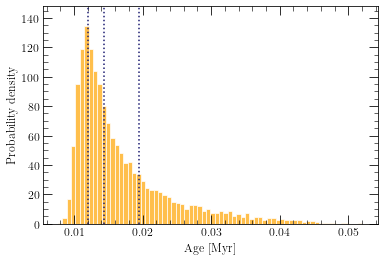

In [46]:
median = np.percentile(t_age,50)
low_lim = np.percentile(t_age,25)
high_lim = np.percentile(t_age,75)
print(median,low_lim,high_lim)
histplot = plt.hist(t_age,bins=70,color='orange',edgecolor='w',density=True,alpha=0.7)
plt.vlines([low_lim,high_lim],0,max(histplot[0])*1.1,linestyles=':',colors='midnightblue')
plt.vlines(median,0,max(histplot[0])*1.1,linestyles=':',colors='midnightblue')
plt.ylim(0,max(histplot[0])*1.1)
plt.ylabel('Probability density', fontsize=12)
plt.xlabel('Age [Myr]', fontsize=12)
#plt.xlim(0,0.2)
#plt.title(str(name))
plt.minorticks_on()
plt.tick_params(axis='both', which='major', labelsize=12)
plt.tick_params(axis='both', which='major', length=9)
plt.tick_params(axis='both', which='minor', length=4.5)
plt.tick_params(axis='both', which='both',direction='in',right=True,top=True)
plt.show()

The evolution of the large-scale structure created by the jet (lobe and bow shock), is self-similar once the jet extends beyond its characteristic length scale, given by (KA97):
$$ L_0 = (\frac{\rho_0^2 Q_0}{\dot{M}_0^3})^{-1/4} = [\frac{Q_0^2}{\rho_0^2 c^6(\gamma_j -1)}]^{1/4}$$

where $\dot{M_0}$ is the mass transport rate of the jet, and $\gamma_j$ is the Lorentz factor of the jet material.


gamma is assumed as1.1, which maximizes L$_{0}$

It is clear that the modelling can be applied, given the characteristic length is smaller than the scale of the jet length.


In [ ]:
# Calculation of L0
rho0 = 2.0e-23 #density in g/cm3
gammaj = 1.1
Q0 = 1.0E+37
L0 = ( (Q0**2) / (rho0**2*c**6*(gammaj-1)) )**(1/4)
print('Characteristic jet length scale [pc] (L0) = ', '{:.3e}'.format(L0/pc))
print('Jet length [pc] (Lj) = ', '{:.3e}'.format(discmP_L/pc))


Characteristic jet length scale [pc] (L0) =  7.842e-05


NameError: name 'discm' is not defined

Assuming that the jet direction remains constant over time,  and that the jet is colliding with a medium of density $\rho_0$, the power Q$_{jet}$ being transported by the jets averaged over its lifetime, **solely dependent on the properties of the ISM** at the interaction site. Combining the equations for $L_j$ and $\dot{L_j}$ we obtain: 


$$ Q_{jet} = (\frac{5}{3})^3~\frac{\rho_0}{C1^5}L_j^2 ~\dot{L_j}^3$$

Things to note here are the differences with the literature. For eg. the C1 constant here has been used as an assumed value of 1 in Gallo et al. 2005 and as 1.5 in Kaiser et al. 2004. The constant C1 depends on the jet opening angle, and a value of 1 implies a jet opening angle of 90deg (unrealistic). The better option would have been measured values of the opening angle but that has not been conclusively done so far. So, we will instead calculate C1 for a range of opening angles (0-30 degree) and use that as a input for the calculation.

The pressure inside the lobe is given by: 

$$ p = 0.0675 \frac{C_1^{10/3}}{R^2}(\frac{\rho_0 Q_0^2}{L_j^4})^{1/3}$$


In [48]:
def power(theta,nee,disamin,vcm):
    theta_rad = theta*math.pi/180           # Jet opening angle, in radiants
    C2 = (((Gammac-1)*(Gammaj-1))/(4*Gammac) + 1 )**(Gammac/(Gammac-1)) * ((Gammaj+1)/(Gammaj-1))
    Rax = math.sqrt((1/4*(C2/theta_rad**2))) # axial ratio of the jet-blown cavity                         
    C3 = math.pi/(4*Rax**2)
    C1 = ((C2)/(C3*theta_rad**2)*((Gammax+1)*(Gammac-1)*(5-beta)**3)/(18*(9*(Gammac + (Gammac -1)*(C2/(4*theta_rad**2))) - 4 - beta)) )**(1/(5-beta))
    #nt=ne/x #where x is the ionisation fraction and is 1, use ne and nt interchangeably in the next equation
    rho = nee*1.370*mh;                    # Density of the gas down-stream of the shock, in cm-3 (calculated above with the calorimetry method above)
    rho0 = rho/4;                         # Density of the gas, up-stream of the shock, in cm-3
    disasec = disamin*60 #lobe target seperation in arcsec (projected)
    dispc = disasec*d*1e3*4.8*1e-6  #lobe target separation in pc (projected)
    discmP = dispc*pc #lobe target sepeartion in cm (projected)
    discm = discmP/math.sin(incl*math.pi/180) #lobe target de-projected seperation to account for the inclination angle
    Pjet = (5/3)**3 * rho0/(C1**5)*discm**2*vcm**3   
    return Pjet

In [49]:
def press(theta,d,nee,disamin,vcm):
    beta = 0
                                           # Theta is the jet opening angle in degrees
                                           # d is the distance in kpc
                                           # nee is the number of electrons
                                           # disamin lobe target seperation in arcsec (projected)
                                           # vcm velocity
    theta_rad = theta*np.pi/180            # Jet opening angle, in radiants
    Con2 = (((Gammac-1)*(Gammaj-1))/(4*Gammac) + 1 )**(Gammac/(Gammac-1)) * ((Gammaj+1)/(Gammaj-1))
    Rax = np.sqrt((1/4*(Con2/theta_rad**2))) # axial ratio of the jet-blown cavity                         
    Con3 = np.pi/(4*Rax**2)
    Con1 = ((Con2)/(Con3*theta_rad**2)*((Gammax+1)*(Gammac-1)*(5-beta)**3)/(18*(9*(Gammac + (Gammac -1)*(Con2/(4*theta_rad**2))) - 4 - beta)) )**(1/(5-beta))
    #nt=ne/x #where x is the ionisation fraction and is 1, use ne and nt interchangeably in the next equation  
    rho = nee*1.370*mh;                    # Density of the gas down-stream of the shock, in cm-3 (calculated above with the calorimetry method above)
    rho0 = rho/4;                          # Density of the gas, up-stream of the shock, in cm-3
    disasec = disamin*60                   # lobe target seperation in arcsec (projected)
    dispc = disasec*d*1e3*4.8*1e-6         # lobe target separation in pc (projected)
    discmP = dispc*pc                      # lobe target sepeartion in cm (projected)
    discm = discmP/np.sin(incl*np.pi/180)  # lobe target de-projected seperation to account for the inclination angle
    Pjet = (5/3)**3 * rho0/(Con1**5)*(discm**2)*vcm**3   # Upper limit to time averaged jet power 
    pminjet = 0.0675*(Con1**(10/3)/Rax**2)*(rho0*Pjet**2/(discm**4))**(1/3)
    return pminjet


In [50]:
# Generating distribution arrays for measurements
#open_angle = np.random.uniform(0,30, n_iter) #opening angle
open_angle = np.logspace(np.log10(0.3),np.log10(2),num=n_iter,base=10,endpoint=True)
ne_constrained = np.random.uniform(ne_overlap_min.min(),ne_overlap_max.max(),n_iter) #from the constraints using Halpha and radio fluxes
#Obtaining distribution of power for different input parameters
power_j = Parallel(n_jobs=n_cores,verbose=5)(delayed(power)(open_angle[i],ne_constrained[i],len_min[i],v_range_cm[i]) for i in range(n_iter))

[Parallel(n_jobs=16)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done 144 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 10000 out of 10000 | elapsed:    0.7s finished


8.201698061031619e+35 1.2834784624428929e+35 3.7230357873979685e+36


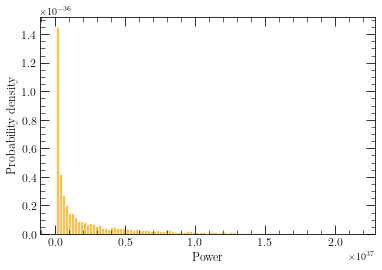

In [51]:
median = np.percentile(power_j,50)
low_lim = np.percentile(power_j,25)
high_lim = np.percentile(power_j,75)
print(median,low_lim,high_lim)
histplot = plt.hist(power_j,color='orange',bins=100,edgecolor='w',density=True,alpha=0.7)
#plt.vlines([low_lim,high_lim],0,max(histplot[0])*1.1,linestyles=':',colors='midnightblue')
#plt.vlines(median,0,max(histplot[0])*1.1,linestyles=':',colors='midnightblue')
#plt.ylim(0,max(histplot[0])*1.1)
plt.ylabel('Probability density', fontsize=12)
plt.xlabel('Power', fontsize=12)
#plt.xlim(0,1e39)
#plt.title(str(name))
plt.minorticks_on()
plt.tick_params(axis='both', which='major', labelsize=12)
plt.tick_params(axis='both', which='major', length=9)
plt.tick_params(axis='both', which='minor', length=4.5)
plt.tick_params(axis='both', which='both',direction='in',right=True,top=True)
plt.show()

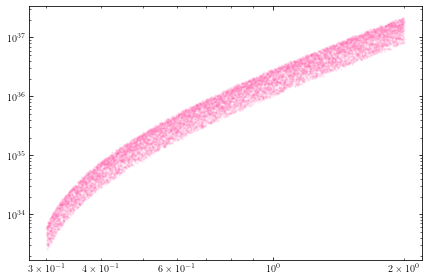

In [42]:
#To plot the variation of power with opening_angle
fig = plt.figure()
ax = fig.add_subplot(111)
ax.yaxis.set_ticks_position('both')
ax.xaxis.set_ticks_position('both')
ax.get_yaxis().set_tick_params(direction='in', which='both')
ax.get_xaxis().set_tick_params(direction='in', which='both')
ax.set_xscale('log')
ax.set_yscale('log')
#ax.set_xlabel(r'Temperature [K]', fontsize=10)
#ax.set_ylabel(r'$n_e(T)$ using Halpha maps [cm$^{-3}$]', fontsize=10)
plt.tight_layout()
#plt.hlines([16,61],1e4,1e8,linestyles=':',colors='black')
plt.scatter(open_angle,power_j,s=2,color='hotpink',alpha=0.1)

In [52]:
#calculating pressure inside bowshock
pressure_j = Parallel(n_jobs=n_cores,verbose=5)(delayed(press)(open_angle[i],dist[i],ne_constrained[i],len_min[i],v_range_cm[i]) for i in range(n_iter))

[Parallel(n_jobs=16)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done 176 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 10000 out of 10000 | elapsed:    0.9s finished


3.000987577165479e-12 6.325534298132714e-13 1.1348757852676542e-11


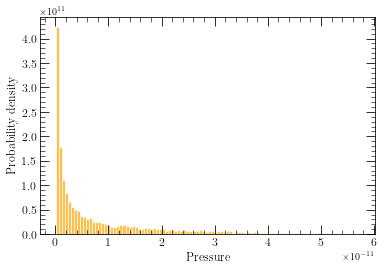

In [53]:
median = np.percentile(pressure_j, 50)
low_lim = np.percentile(pressure_j, 25)
high_lim = np.percentile(pressure_j, 75)
print(median, low_lim, high_lim)
histplot = plt.hist(pressure_j, color='orange', bins=100, edgecolor='w', density=True, alpha=0.7)
#plt.vlines([low_lim,high_lim],0,max(histplot[0])*1.1,linestyles=':',colors='midnightblue')
#plt.vlines(median,0,max(histplot[0])*1.1,linestyles=':',colors='midnightblue')
#plt.ylim(0,max(histplot[0])*1.1)
plt.ylabel('Probability density', fontsize=12)
plt.xlabel('Pressure', fontsize=12)
#plt.xlim(0,1e39)
#plt.title(str(name))
plt.minorticks_on()
plt.tick_params(axis='both', which='major', labelsize=12)
plt.tick_params(axis='both', which='major', length=9)
plt.tick_params(axis='both', which='minor', length=4.5)
plt.tick_params(axis='both', which='both', direction='in', right=True, top=True)
plt.show()

In [ ]:
open_a = np.random.uniform(1,20, n_iter) #opening angle
g_c = np.random.uniform(4/3,5/3, n_iter) #opening angle
g_j = np.random.uniform(4/3,5/3, n_iter) #opening angle

### Variation of C constants with opening angle

In [ ]:
def C_cons(g_c,g_j,g_x,ope):
    theta_ra = ope*math.pi/180           # Jet opening angle, in radiants
    C2_0 = (((g_c-1)*(g_j-1))/(4*g_c) + 1 )**(g_c/(g_c-1)) * ((g_j+1)/(g_j-1))
    Rax_0 = math.sqrt((1/4*(C2/theta_ra**2))) # axial ratio of the jet-blown cavity                         
    C3_0 = math.pi/(4*Rax_0**2)
    C1_0 = ((C2_0)/(C3_0*theta_ra**2)*((g_x+1)*(g_c-1)*(5-beta)**3)/(18*(9*(g_c + (g_c -1)*(C2/(4*theta_ra**2))) - 4 - beta)) )**(1/(5-beta))
    return C1_0

In [ ]:
ce_1 = Parallel(n_jobs=n_cores,verbose=5)(delayed(C_cons)(g_c[i],g_j[i],(5.0/3),open_a[i]) for i in range(n_iter))


In [ ]:
median = np.percentile(ce_1,50)
low_lim = np.percentile(ce_1,5)
high_lim = np.percentile(ce_1,95)
print(median,low_lim,high_lim)
histplot = plt.hist(ce_1,bins=70,color='orange',edgecolor='w',density=True,alpha=0.7)
plt.vlines([low_lim,high_lim],0,max(histplot[0])*1.1,linestyles=':',colors='midnightblue')
plt.vlines(median,0,max(histplot[0])*1.1,linestyles=':',colors='midnightblue')
plt.ylim(0,max(histplot[0])*1.1)
plt.ylabel('Probability density', fontsize=12)
plt.xlabel('C1 constant', fontsize=12)
#plt.xlim(0,400)
plt.title('Varying all three')
plt.minorticks_on()
plt.tick_params(axis='both', which='major', labelsize=12)
plt.tick_params(axis='both', which='major', length=9)
plt.tick_params(axis='both', which='minor', length=4.5)
plt.tick_params(axis='both', which='both',direction='in',right=True,top=True)
plt.show()

In [ ]:
ce_1 = Parallel(n_jobs=n_cores,verbose=5)(delayed(C_cons)(g_c[i],(5.0/3),(5.0/3),open_a[i]) for i in range(n_iter))
median = np.percentile(ce_1,50)
low_lim = np.percentile(ce_1,5)
high_lim = np.percentile(ce_1,95)
print(median,low_lim,high_lim)
histplot = plt.hist(ce_1,bins=70,color='orange',edgecolor='w',density=True,alpha=0.7)
plt.vlines([low_lim,high_lim],0,max(histplot[0])*1.1,linestyles=':',colors='midnightblue')
plt.vlines(median,0,max(histplot[0])*1.1,linestyles=':',colors='midnightblue')
plt.ylim(0,max(histplot[0])*1.1)
plt.ylabel('Probability density', fontsize=12)
plt.xlabel('C1 constant', fontsize=12)
#plt.xlim(0,400)
plt.title('Without varying g_j')
plt.minorticks_on()
plt.tick_params(axis='both', which='major', labelsize=12)
plt.tick_params(axis='both', which='major', length=9)
plt.tick_params(axis='both', which='minor', length=4.5)
plt.tick_params(axis='both', which='both',direction='in',right=True,top=True)
plt.show()

In [ ]:
ce_1 = Parallel(n_jobs=n_cores,verbose=5)(delayed(C_cons)((5.0/3),g_j[i],(5.0/3),open_a[i]) for i in range(n_iter))
median = np.percentile(ce_1,50)
low_lim = np.percentile(ce_1,5)
high_lim = np.percentile(ce_1,95)
print(median,low_lim,high_lim)
histplot = plt.hist(ce_1,bins=70,color='orange',edgecolor='w',density=True,alpha=0.7)
plt.vlines([low_lim,high_lim],0,max(histplot[0])*1.1,linestyles=':',colors='midnightblue')
plt.vlines(median,0,max(histplot[0])*1.1,linestyles=':',colors='midnightblue')
plt.ylim(0,max(histplot[0])*1.1)
plt.ylabel('Probability density', fontsize=12)
plt.xlabel('C1 constant', fontsize=12)
#plt.xlim(0,400)
plt.title('Without varying g_c')
plt.minorticks_on()
plt.tick_params(axis='both', which='major', labelsize=12)
plt.tick_params(axis='both', which='major', length=9)
plt.tick_params(axis='both', which='minor', length=4.5)
plt.tick_params(axis='both', which='both',direction='in',right=True,top=True)
plt.show()

In [61]:
# This is adapted from the ThunderBook "Equipartition analysis" (https://github.com/robfender/ThunderBooks)
#For L-band luminosity
D = d
k = 0.01          
nu1 = 0.855e9
nu2 = 1.7e9
p=2.8 #assuming spectral index of -0.9
alpha=(1.0-p)/2.0
eta = 1
f = 1

# Pseudoconstant
c1=6.27e18
c2=2.37e-3
# speed of light 
c=3.0e10
# relativistic sound speed of c/sqrt[3]
cs=c/(3.0**0.5)

ctildetop=(nu1**((2.0-p)/2.0))-(nu2**((2.0-p)/2.0))
ctildebottom=(nu1**((3.0-p)/2.0))-(nu2**((3.0-p)/2.0))
ctilde=((p-3.0)/(p-2.0))*(ctildetop/ctildebottom)
c12=(c2**-1.0)*(c1**0.5)*ctilde

def LumTot(snu2,D,nu1,nu2,alpha): 
# here s is the flux density at the upper frequency nu2
    L2 = 4 * np.pi * ((D * 3.1e21)**2.0) * (snu2 * 1e-26) * (nu2**(-alpha)) * ((nu2**(1+alpha))-(nu1**(1+alpha))) / (1+alpha)
    #print (('Calculated total radiative luminosity'),('L ='),('%.2e' % L2),(' erg / sec '))
    return L2

L = LumTot(F_total_L,d,nu1,nu2,alpha)    #  Note that this is the INTEGRATED luminosity, not the monochromatic one
Bmin = (6*np.pi*(eta/f)*c12*Lcy/proj_vol_cm_L)**(2/7)  # Equipartition magnetic field, Gauss

# Total pressure in this feature for minimum energy conditions

pmin = 7/9*Bmin**(2)/(8*np.pi)*(k+1)       # Equipartition pressure, erg/cm3


print('Integrated Luminosity [erg/s] (L) =','{:.3e}'.format(L))
print('Magnetic field density [G] (Bmin) = ','{:.3e}'.format(Bmin))
print('Pressure [erg/cm3] (pmin) ~','{:.3e}'.format(pmin))


Cylinder Integrated Luminosity [erg/s] (Lcy) = 3.097e+26
>> Cylinder magnetic field density [G] (Bmin) =  1.310e-06
>> Cylinder pressure [erg/cm3] (pmincyl) ~ 5.364e-14


In [63]:
#For S-band luminosity
D = d
k = 0.01          
nu1 = 2.182e9
nu2 = 3.048e9
p=2.8
alpha=(1.0-p)/2.0
eta = 1
f = 1

# Pseudoconstant
c1=6.27e18
c2=2.37e-3
# speed of light 
c=3.0e10
# relativistic sound speed of c/sqrt[3]
cs=c/(3.0**0.5)

ctildetop=(nu1**((2.0-p)/2.0))-(nu2**((2.0-p)/2.0))
ctildebottom=(nu1**((3.0-p)/2.0))-(nu2**((3.0-p)/2.0))
ctilde=((p-3.0)/(p-2.0))*(ctildetop/ctildebottom)
c12=(c2**-1.0)*(c1**0.5)*ctilde

def LumTot(snu2,D,nu1,nu2,alpha): 
# here s is the flux density at the upper frequency nu2
    L2 = 4 * np.pi * ((D * 3.1e21)**2.0) * (snu2 * 1e-26) * (nu2**(-alpha)) * ((nu2**(1+alpha))-(nu1**(1+alpha))) / (1+alpha)
    #print (('Calculated total radiative luminosity'),('L ='),('%.2e' % L2),(' erg / sec '))
    return L2

L = LumTot(F_total_S,d,nu1,nu2,alpha)    #  Note that this is the INTEGRATED luminosity, not the monochromatic one
Bmin = (6*np.pi*(eta/f)*c12*Lcy/proj_vol_cm_L)**(2/7)  # Equipartition magnetic field, Gauss

# Total pressure in this feature for minimum energy conditions

pmin = 7/9*Bmin**(2)/(8*np.pi)*(k+1)       # Equipartition pressure, erg/cm3


print('Integrated Luminosity [erg/s] (L) =','{:.3e}'.format(L))
print('>> Magnetic field density [G] (Bmin) = ','{:.3e}'.format(Bmin))
print('>> Pressure [erg/cm3] ~','{:.3e}'.format(pmin))


Cylinder Integrated Luminosity [erg/s] (Lcy) = 3.471e+26
>> Cylinder magnetic field density [G] (Bmin) =  8.024e-07
>> Cylinder pressure [erg/cm3] (pmincyl) ~ 2.012e-14
